Notebook structure
It is best to think about your final project as a data-driven report. You will need to put everything into a Jupyter notebook with the following structure:

- Introduction: Introduce the project, and your approach, talk about the process of how you came up with the metric and some alternatives you may have explored.
- The Metric: Describe your metric, and what features are you measuring. What datasets are you using?
- The Best Neighborhood: Apply the metric from the previous section to determine the best neighborhood in Pittsburgh. Beyond just executing code, provide a narrative about why you think this is the best neighborhood. Incorporate a data visualization, perhaps to rank all of the neighborhoods or show a neighborhood’s best-ness over time. The key is to make a data driven argument.
- Conclusion: Reflect on how the data-driven determination of “best neighborhood” is the same or different from your personal favorite neighborhood. Each member of the group should write their own response to this.

This makes a weighted graph with all of our metrics. This graph is made by calculating the proportion of its metric it fills up, and then combining it into one graph. Only neighborhoods that have data from all 3 data sets are included. Here is how everything is weighted:
Amount of facilities: 20%
Amount of important facilities: 20%
Education Score: 40%
Sqft of parks: 20%

In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import geopandas
data = pd.read_csv("https://data.wprdc.org/datastore/dump/fbb50b02-2879-47cd-abea-ae697ec05170")
df = pd.read_csv("Pittsburgh Education 2024.csv")
parks_area = pd.read_csv("ParkData2.csv")
parks_info = pd.read_csv("parkdata.csv")
neighborhoods = geopandas.read_file("Neighborhoods/Neighborhoods_.shp")

In [3]:
#DATA SET 1

# Jack A
facilities = data["neighborhood"].value_counts().sort_values(ascending=False) 
facilities_weighted = 0.2 * facilities / 412
#print(facilities.head())
#facilities_query_mask = facilities_weighted > 0.02

# Jack B
least_important = ["OFFICE", "Office", "Salt Dome", "TRAINING", "Training", "Pool Closed", "Vacant", "Storage", "STORAGE", 
                   "SERVICE", "Service", "Concession", "Dugout", "Shelter", "Cabin", "Restrooms", "Utility"]
data_filtered = data[~data["type"].isin(least_important)]
data_filtered_grouped = data_filtered["neighborhood"].value_counts().sort_values(ascending=False)
important_facilities = 0.2 * (data_filtered_grouped / 132)

# lenny
school_counts = df['Neighborhood'].value_counts()
valid_neighborhoods = school_counts[school_counts >= 2].index
stability = df[df['Neighborhood'].isin(valid_neighborhoods)].groupby('Neighborhood')['Student Stability Rate'].mean()
approval = df[df['Neighborhood'].isin(valid_neighborhoods)].groupby('Neighborhood')['Teacher Approval Rate'].mean()
ratio_inverse = 100 - df[df['Neighborhood'].isin(valid_neighborhoods)].groupby('Neighborhood')['Student/Teacher Ratio'].mean()
combined = pd.concat([stability, approval, ratio_inverse], axis=1)
combined.columns = ['Stability', 'Approval', '100 - Ratio']
combined['Best Education Score'] = combined.mean(axis=1).sort_index()
bars = combined['Best Education Score'].sort_index().plot(kind='bar', color='orange', edgecolor='black')
combined['Best Education Score'].sort_values().cumsum()
# total score:  1041.846150
combined['Weighted Education Score'] = 0.4 * combined['Best Education Score'] / 1041.846150
education_weighted = combined.drop(['Best Education Score', 'Stability','Approval','100 - Ratio'],axis=1)
education_weighted = education_weighted.reset_index()# = 'neighborhood'
education_weighted = education_weighted.rename(columns={'Neighborhood': 'neighborhood'})
education_weighted = education_weighted.set_index('neighborhood')['Weighted Education Score']
#education_weighted.head()

# Nate
area = parks_area[['updatepknm', 'sqft']].copy() #keep only updated park name and sqr footage columns
area.rename(columns={'updatepknm': 'park_name'}, inplace=True) #rename the updated park name column so both files have the same name
info = parks_info[['name', 'neighborhood']].copy() #keep only the park name and neighborhood columns
info.rename(columns={'name': 'park_name'}, inplace=True) #rename the updated park name column so both files have the same name
area['park_name'] = area['park_name'].astype(str).str.strip().str.lower() #cleaning up the names so they match (made them lowercase and took away spaces)
info['park_name'] = info['park_name'].astype(str).str.strip().str.lower()
area['sqft'] = pd.to_numeric(area['sqft'], errors='coerce') #make the sqr footage numeric
merged = pd.merge(area, info, on='park_name', how='inner') #merge the two datasets with the cleaned up park names
neigh_totals = (merged.groupby('neighborhood', as_index=False)['sqft'].sum().sort_values('sqft', ascending=False)) #group the data by the neighborhood and add the sqr footage
#print(neigh_totals['sqft'].sum())
# 119731871.09870426 | total sqft
park_weighted = neigh_totals.set_index('neighborhood')['sqft']
park_weighted = 0.2 * park_weighted / 119731871.09870426
#park_weighted_mask = park_weighted > 10000
#park_weighted = park_weighted[park_weighted_mask]
#print(park_weighted.sort_values(ascending=False).head())

In [4]:
# for normal bar graph | NOT USING ANYMORE

#data_concat = pd.concat([important_facilities,facilities_weighted,education_weighted,park_weighted])
#data_combined = data_concat.groupby('neighborhood').sum().sort_values(ascending=False)
#data_combined_mask = data_combined > 0.01
#data_combined[data_combined_mask].plot.bar()
#plt.title('Weighted Rating of Neighborhoods')
#plt.show()


# for stacked bar graph  
merged = pd.merge(important_facilities, facilities_weighted, on='neighborhood', how='outer', suffixes=('_important', '_normal')).fillna(0)
merged = pd.merge(merged, park_weighted, left_on='neighborhood',right_on='neighborhood').fillna(0)
merged = pd.merge(merged, education_weighted, left_on='neighborhood',right_on='neighborhood').fillna(0)
merged['total'] = merged['count_important'] + merged['count_normal'] + merged['Weighted Education Score'] + merged['sqft']
merged = merged.sort_values('total', ascending=False)
#print(merged['total'].cumsum())
merged_graphthis = merged.drop('total', axis=1)
merged_graphthis[data_combined_mask].plot(kind='bar',stacked=True,ylabel='Count',title='Counts by Source (Stacked)')
plt.show()
# .46 + .37

NameError: name 'data_combined_mask' is not defined

In [5]:
facilities = data["neighborhood"].value_counts().sort_values(ascending=False) 
facilities_query_mask = facilities > 10
facilities[facilities_query_mask].plot.bar()
#plt.show()

<Axes: xlabel='neighborhood'>

In [6]:
least_important = ["OFFICE", "Office", "Salt Dome", "TRAINING", "Training", "Pool Closed", "Vacant", "Storage", "STORAGE", 
                   "SERVICE", "Service", "Concession", "Dugout", "Shelter", "Cabin", "Restrooms", "Utility"]
data_filtered = data[~data["type"].isin(least_important)]
data_filtered_grouped = data_filtered["neighborhood"].value_counts().sort_values(ascending=False)
amt_query_mask_filtered = data_filtered_grouped > 3
data_filtered_grouped[amt_query_mask_filtered].plot.bar()
#plt.show()

# edit axis, labels, etc

<Axes: xlabel='neighborhood'>

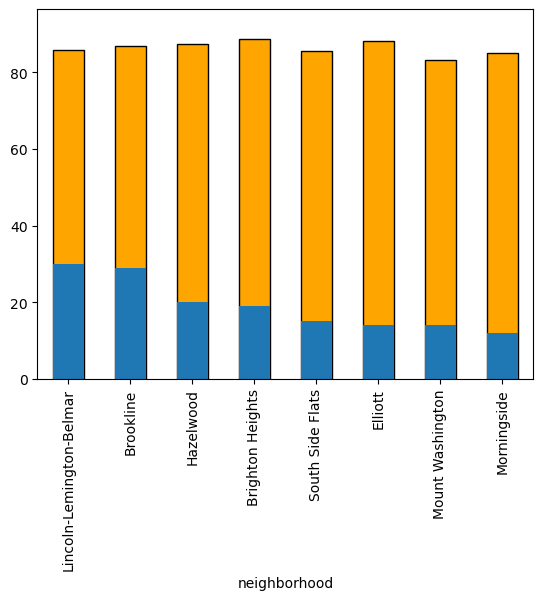

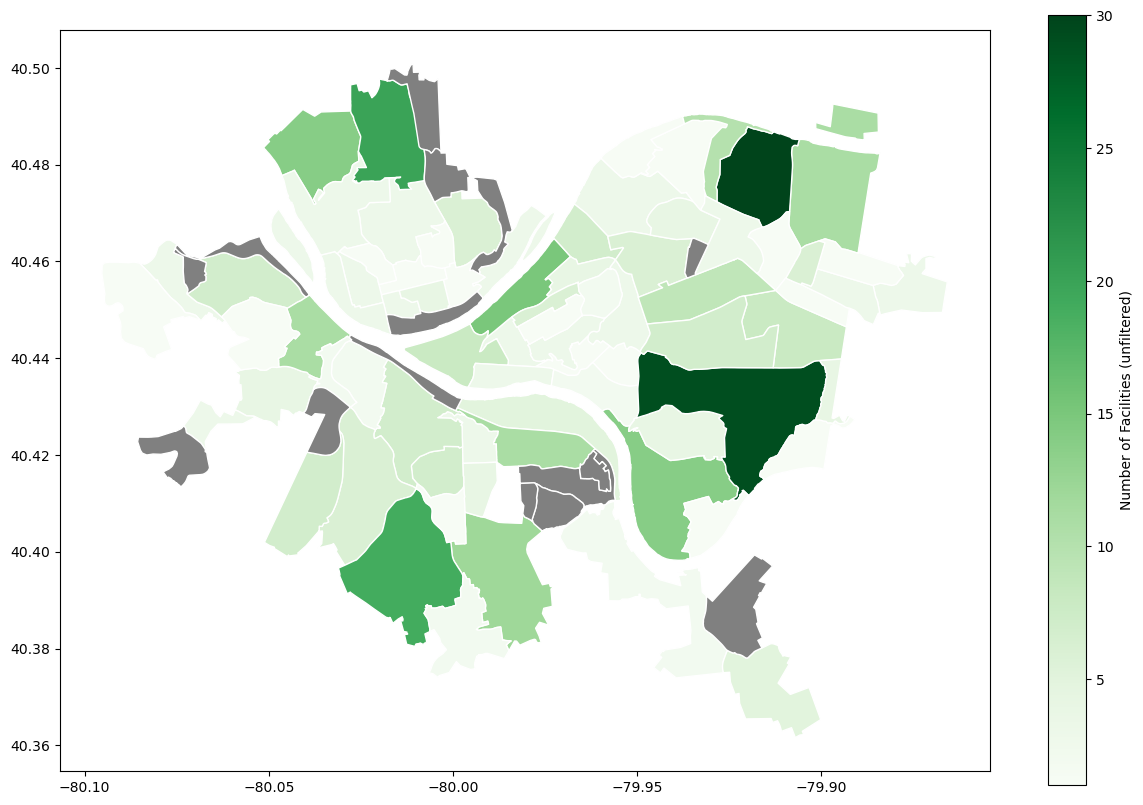

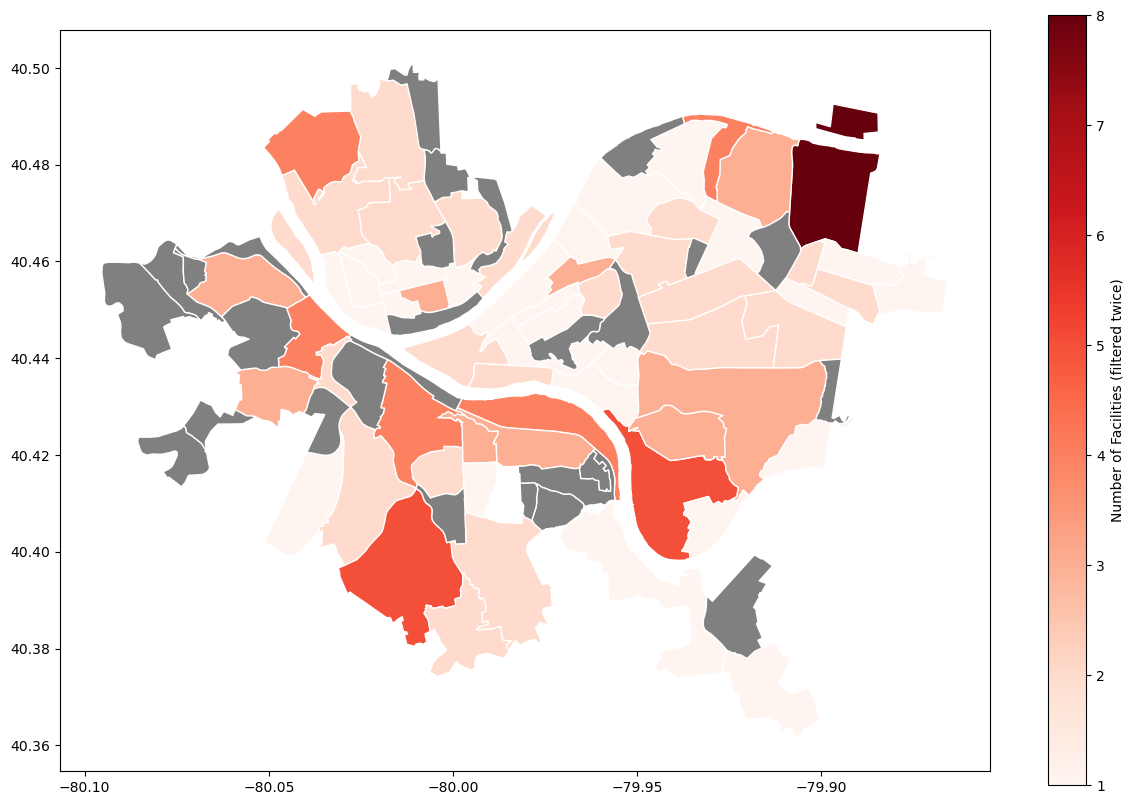

In [7]:
# Some code borrowed from geopandas example in lab lesson

facilities.name = "facAmt"
facilities_map = neighborhoods.merge(facilities, how='left', left_on='hood', right_on='neighborhood')
pd.set_option('display.max_columns', None)
facilities_map.plot(column='facAmt', # set the data to be used for coloring
               cmap="Greens",              # choose a color palette
               edgecolor="white",        # outline the districts in white
               legend=True,              # show the legend
               legend_kwds={'label': "Number of Facilities (unfiltered)"}, # label the legend
               figsize=(15, 10),         # set the size
               missing_kwds={"color": "gray"} # set disctricts with no data to gray
               )

data_filtered_grouped.name = "DFG"
facilities_map = neighborhoods.merge(data_filtered_grouped, how='left', left_on='hood', right_on='neighborhood')
pd.set_option('display.max_columns', None)
facilities_map.plot(column='DFG', # set the data to be used for coloring
               cmap="Reds",              # choose a color palette
               edgecolor="white",        # outline the districts in white
               legend=True,              # show the legend
               legend_kwds={'label': "Number of Facilities (filtered twice)"}, # label the legend
               figsize=(15, 10),         # set the size
               missing_kwds={"color": "gray"} # set disctricts with no data to gray
               )
plt.show()



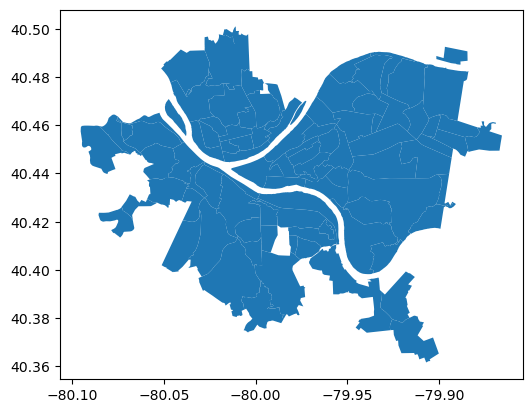

In [8]:
# SAMPLE GEOPANDAS (groupmates you can use this)

neighborhoods = geopandas.read_file("Neighborhoods/Neighborhoods_.shp")
neighborhoods.plot() # plot the geopandas dataframe
plt.show()

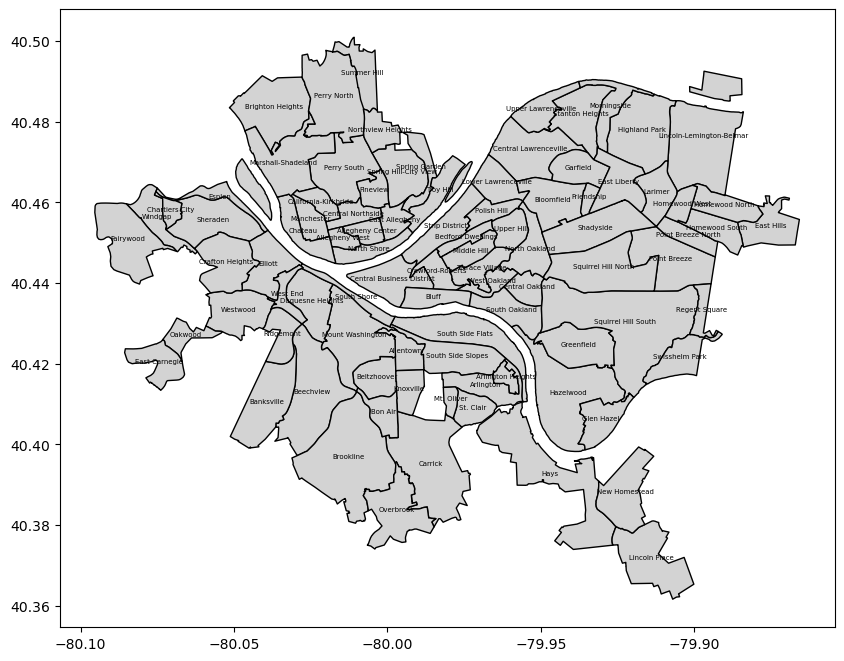

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
neighborhoods.plot(ax=ax, color='lightgray', edgecolor='black')
for idx, row in neighborhoods.iterrows():
        centroid = row.geometry.centroid
        label = row["hood"]
        ax.annotate(text=label, 
                    xy=(centroid.x, centroid.y), 
                    horizontalalignment='center', 
                    color='black', 
                    fontsize=5)
plt.show()


In [10]:
eLiberty_data = data[data["neighborhood"]  == "East Liberty"]
type_counts = eLiberty_data["type"].value_counts()
type_counts.head()
#plt.figure(figsize=(6, 6))
#type_counts.plot(kind="pie", autopct="%1.1f%%")
#plt.show()

type
Utility      2
Firehouse    1
Name: count, dtype: int64

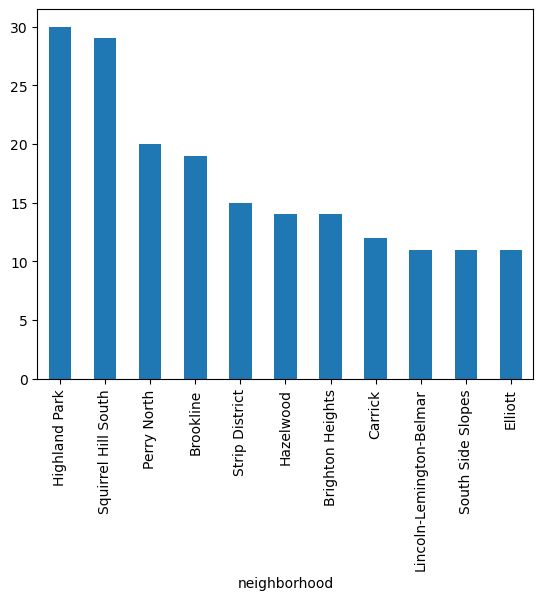

In [11]:
data_test = data["neighborhood"].value_counts().sort_values(ascending=False)
data_query_mask = data_test > 10
data_test[data_query_mask].plot.bar()
plt.show()